# REP or DEM <br> LSTM classification report

Paul Elvis Otto (Duke University / Hertie School)

## Intro

Classifiying tweets is probably one the most done tasks in machine learining. This project classifiest tweets of the 112th congres into either being macde by a democrat or a republican. The dataset is taken from the harvard dataverse and contains the posts themself, the author of it, the party affiliation and whether the post was made in the house or the senate.

For the classficiaitn task a bidirectional LSTM has been used, which is described in the model section. The model is trained from scratch without any pretraining. For the classification embeddings are used which have been imported from huggingface. As a baseliune a naive bayes classifier has been used the comparison is shown in the empirical assessment section.

To get an overall impression of the dataset an EDA has been performed, which is shown in @sec-eda.

The dataset has been cleaned for the processing by the BILSTM, more detail in @sec-data-prep.

## Data Preparation

To make the data workable and not conditionn on things like dates, mentios or links the posts each have been cleaned from that with the help of different regexes. The script to cleaning can be view in the repository of the model. The scope of the cleanned data is as follwos:

-   DAtes removed
-   Mentions removed
-   Hashtags removed

## EDA

To give an insisht into the dataset first there are some basic metrics

In [ ]:
library(dplyr)

df <- read.csv("./data/congress_complete_clean.csv")
shape <- dim(df)

The dataset has the shape of 334606, 5 and the posts are distributed as follows:

The overall distribution of posts by chamber and party is shown in @fig-post-dist .

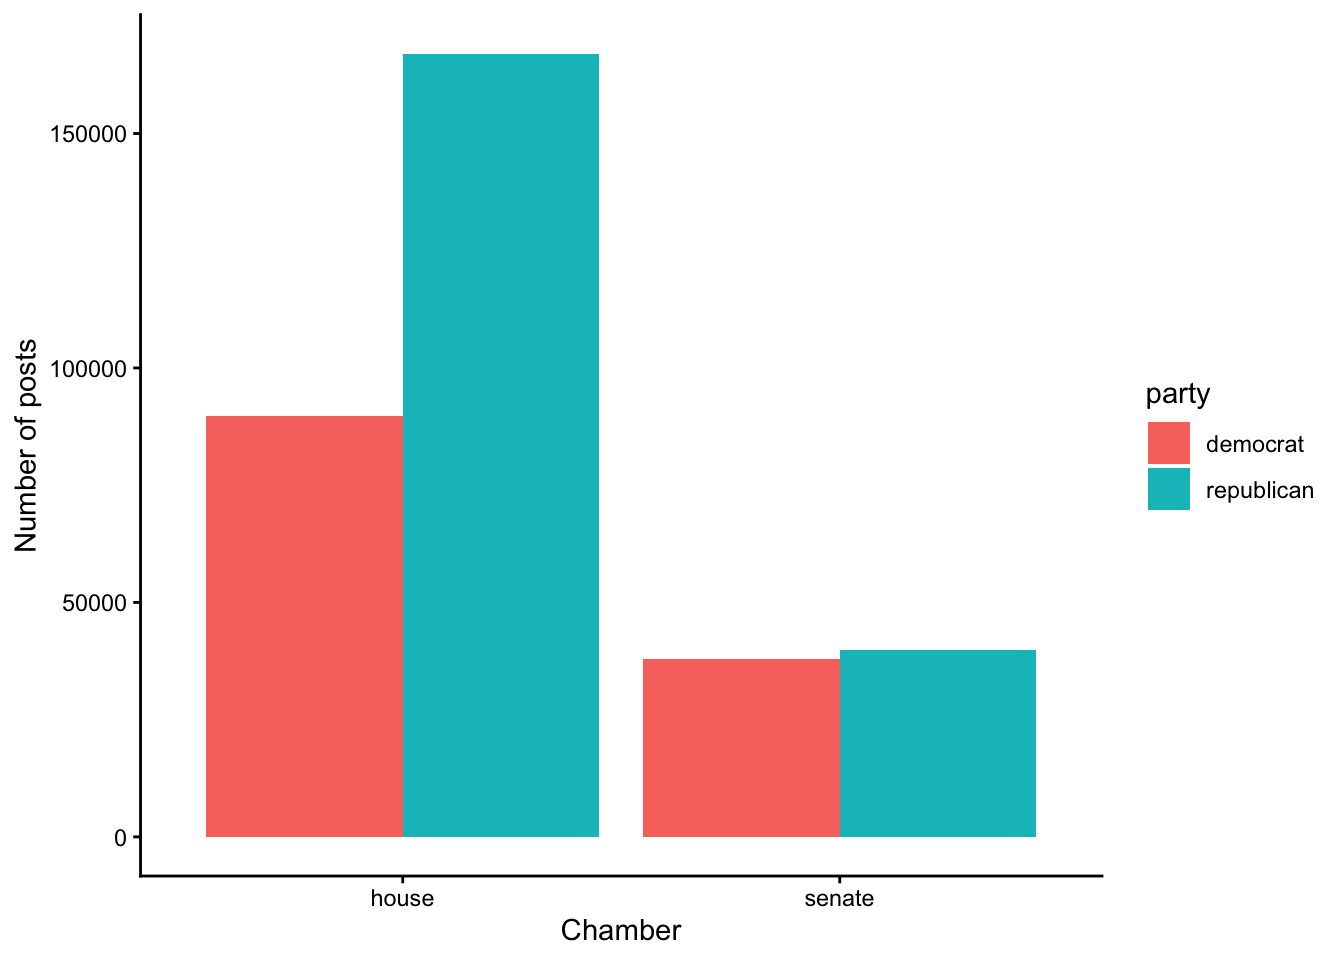

In [ ]:
library(dplyr)
library(ggplot2)

df_counts <- df %>%
  count(organ, party)

ggplot(df_counts, aes(x = organ, y = n, fill = party)) +
  geom_col(position = "dodge") +
  labs(x = "Chamber", y = "Number of posts") +
  theme_classic()

In totatl numbers the posts per party are as follows:

In [ ]:
library(dplyr)
library(tidyr)
library(gt)

df_table <- df %>%
  count(organ, party) %>%
  pivot_wider(
    names_from = party,
    values_from = n,
    values_fill = 0
  )

df_table %>%
  gt(rowname_col = "organ") %>%
  tab_header(
    title = "Number of Posts by Chamber and Party"
  ) %>%
  cols_label(
    organ = "Chamber"
  )

The distribution of post lengths is as follows:

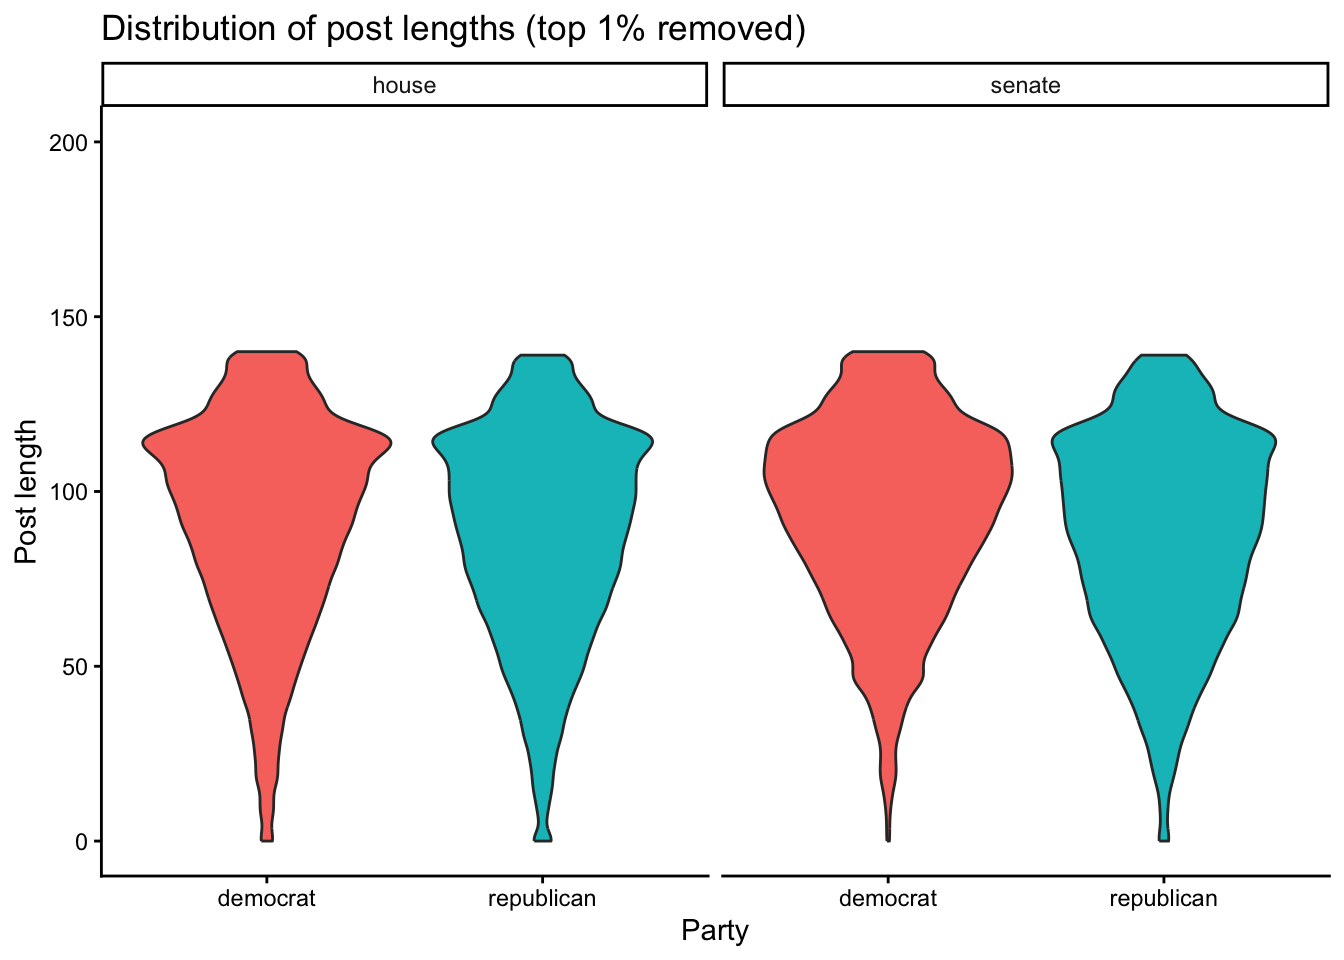

In [ ]:
library(dplyr)
library(ggplot2)
library(stringr)

df_clean <- df %>%
  mutate(length = str_length(post)) %>%
  group_by(party, organ) %>%
  mutate(cutoff = quantile(length, 0.99, na.rm = TRUE)) %>%
  ungroup() %>%
  filter(length <= cutoff)

ggplot(df_clean, aes(x = party, y = length, fill = party)) +
  geom_violin(trim = TRUE) +
  facet_wrap(~organ) +
  coord_cartesian(ylim = c(0, 200)) + # set y-axis range
  labs(
    x = "Party",
    y = "Post length",
    title = "Distribution of post lengths (top 1% removed)"
  ) +
  theme_classic() +
  theme(legend.position = "none")

The top posters in the dataset:

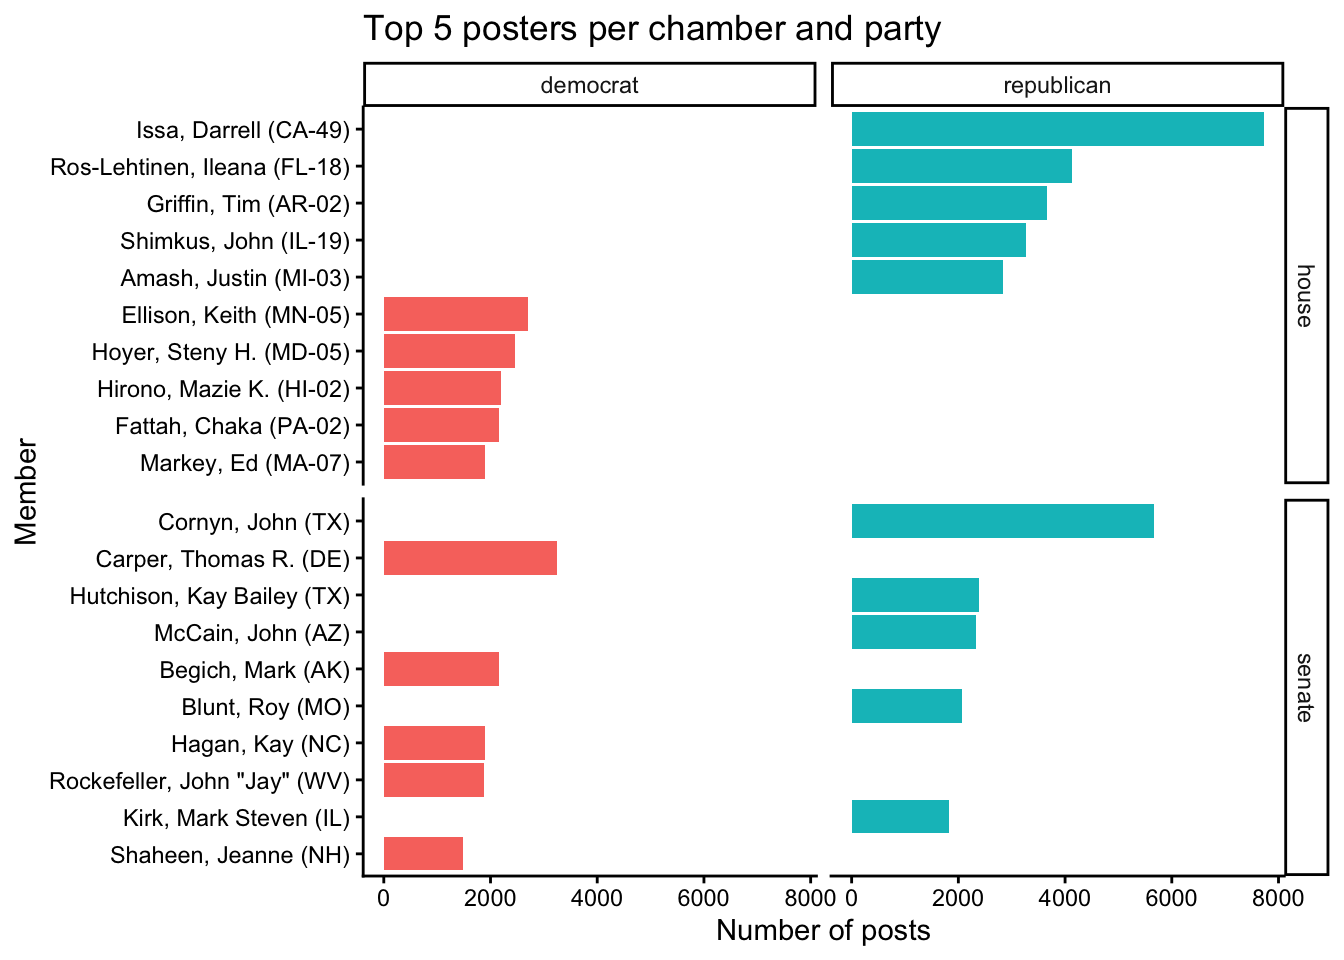

In [ ]:
library(dplyr)
library(ggplot2)

df_top <- df %>%
  count(organ, party, member, name = "posts") %>% # count posts
  group_by(organ, party) %>% # group by chamber + party
  slice_max(order_by = posts, n = 5, with_ties = FALSE) %>% # keep top 5 only
  ungroup()

ggplot(df_top, aes(x = reorder(member, posts), y = posts, fill = party)) +
  geom_col() +
  coord_flip() +
  facet_grid(organ ~ party, scales = "free_y") +
  labs(
    x = "Member",
    y = "Number of posts",
    title = "Top 5 posters per chamber and party"
  ) +
  theme_classic() +
  theme(legend.position = "none")

Some word frequencies by party

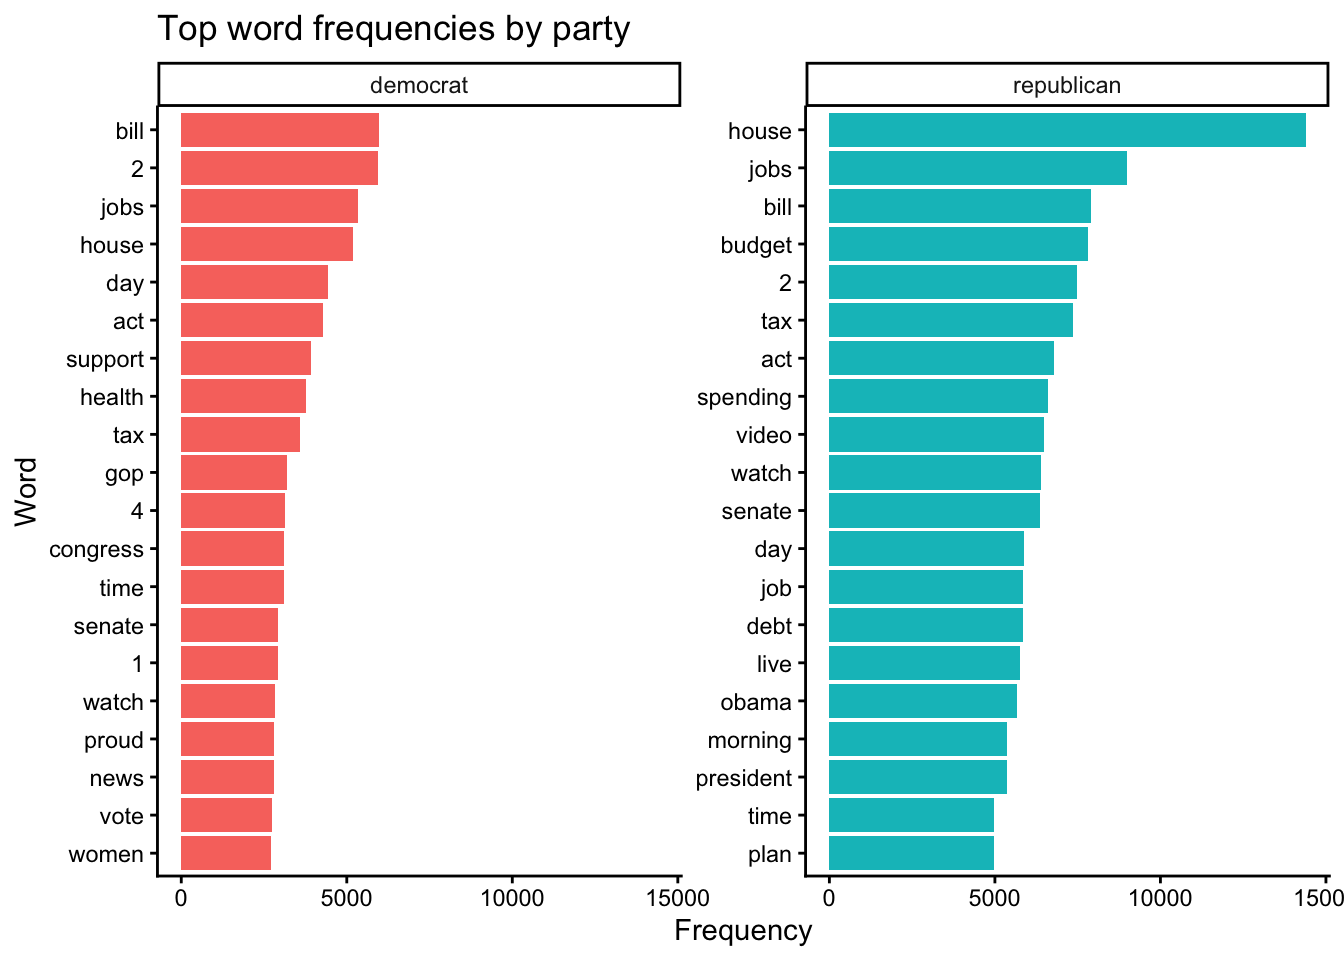

In [ ]:
library(dplyr)
library(tidytext)
library(ggplot2)
library(stringr)

# optional: custom stopwords
custom_stop <- tibble(word = c("rt"))

# prepare word frequencies
df_words <- df %>%
  mutate(post = str_to_lower(post)) %>%
  unnest_tokens(word, post) %>%
  anti_join(stop_words, by = "word") %>%
  anti_join(custom_stop, by = "word") %>%
  filter(word != "") %>%
  count(party, word, sort = TRUE)

# select top N words per party
top_n_words <- 20

df_top <- df_words %>%
  group_by(party) %>%
  slice_max(order_by = n, n = top_n_words) %>%
  ungroup()

# plot side-by-side word frequency charts
ggplot(df_top, aes(x = reorder_within(word, n, party), y = n, fill = party)) +
  geom_col() +
  coord_flip() +
  facet_wrap(~party, scales = "free_y") +
  scale_x_reordered() +
  labs(
    x = "Word",
    y = "Frequency",
    title = "Top word frequencies by party"
  ) +
  theme_classic() +
  theme(legend.position = "none")

## Model specification

### Tokenization and inputs

Each text is mapped to a fixed-length sequence of subword token identifiers using a WordPiece-style tokenizer with vocabulary size $V$. After padding or truncation to length $T=128$, each sample is represented by:

$$
\mathbf{t}=(t_1,\dots,t_T),\quad t_i \in \{1,\dots,V\},
$${#eq-token-seq}

and a binary mask

$$
\mathbf{m}=(m_1,\dots,m_T),\quad m_i\in\{0,1\},
$${#eq-mask-seq}

where $m_i=1$ indicates a true token and $m_i=0$ indicates padding. The tokenizer is used only to obtain indices; semantic representations are learned by the network.

### Trainable embedding layer

Let $E\in\mathbb{R}^{V\times d}$ be the embedding matrix with $d=200$. Tokens are embedded as

$$
\mathbf{x}_i = E[t_i]\in\mathbb{R}^{d},
\quad
\mathbf{X}=(\mathbf{x}_1,\dots,\mathbf{x}_T)\in\mathbb{R}^{T\times d}.
$${#eq-embed-seq}

The padding index is set so that padded positions do not update embeddings.

### Bidirectional LSTM encoder

A forward LSTM and a backward LSTM encode $\mathbf{X}$. For a single LSTM direction, gates and state updates at timestep $i$ are:

$$
\begin{align}
\mathbf{i}_i &= \sigma(W_i\mathbf{x}_i + U_i\mathbf{h}_{i-1} + \mathbf{b}_i), \\
\mathbf{f}_i &= \sigma(W_f\mathbf{x}_i + U_f\mathbf{h}_{i-1} + \mathbf{b}_f), \\
\mathbf{o}_i &= \sigma(W_o\mathbf{x}_i + U_o\mathbf{h}_{i-1} + \mathbf{b}_o), \\
\tilde{\mathbf{c}}_i &= \tanh(W_c\mathbf{x}_i + U_c\mathbf{h}_{i-1} + \mathbf{b}_c), \\
\mathbf{c}_i &= \mathbf{f}_i\odot \mathbf{c}_{i-1} + \mathbf{i}_i\odot \tilde{\mathbf{c}}_i, \\
\mathbf{h}_i &= \mathbf{o}_i\odot \tanh(\mathbf{c}_i),
\end{align}
$${#eq-lstm-gates}

with sigmoid $\sigma(\cdot)$ and elementwise product $\odot$. The hidden size is $H=128$ per direction. The bidirectional representation at position $i$ is

$$
\mathbf{h}_i = [\overrightarrow{\mathbf{h}}_i ; \overleftarrow{\mathbf{h}}_i] \in \mathbb{R}^{2H},
$${#eq-bilstm-concat}

yielding a sequence output

$$
\mathbf{H}=(\mathbf{h}_1,\dots,\mathbf{h}_T)\in\mathbb{R}^{T\times 2H}.
$${#eq-seq-output}

### Masked mean pooling

To obtain a fixed-dimensional vector while excluding padding, the model computes:

$$
\mathbf{z}=
\frac{\sum_{i=1}^{T} m_i \mathbf{h}_i}
{\sum_{i=1}^{T} m_i + \varepsilon}
\in\mathbb{R}^{2H},
$${#eq-fix-dim-vex}

where $\varepsilon$ is a small constant to avoid division by zero.

### Classification head

Dropout is applied to $\mathbf{z}$ with probability $p=0.2$:

$$
\tilde{\mathbf{z}}=\mathrm{Dropout}(\mathbf{z}).
$$

A linear layer produces logits:

$$
\mathbf{o}=W\tilde{\mathbf{z}}+\mathbf{b}\in\mathbb{R}^{2}.
$$

The predictive distribution is

$$
\hat{\mathbf{y}}=\mathrm{softmax}(\mathbf{o}),
\qquad
\hat{y}=\arg\max_{k\in\{0,1\}} \hat{\mathbf{y}}_k.
$$

### Training objective

Parameters $\theta$ are learned by minimizing the cross-entropy loss:

$$
\mathcal{L}(\theta)
-\frac{1}{N}
\sum_{n=1}^{N}
\log \hat{\mathbf{y}}^{(n)}_{y^{(n)}}.
$$

Optimization uses AdamW with learning rate $10^{-3}$. Mixed-precision training (automatic casting to FP16 with dynamic gradient scaling) is employed to improve throughput and numerical stability on modern GPUs.

### Computational considerations

For each batch, the dominant cost arises from the BiLSTM. For sequence length $T$ and hidden size $H$, time complexity scales as $\mathcal{O}(T\cdot H^2)$ per direction, and memory scales as $\mathcal{O}(T\cdot H)$ for storing activations. Fixing $T=128$ stabilizes runtime and enables cuDNN kernel autotuning.

## Implementation details

### Environment and reproducibility

Training is performed on CUDA hardware with cuDNN benchmarking activated, selecting optimized kernels for the fixed tensor shapes. Random seeds are set for Python, NumPy, and PyTorch (CPU and GPU) to reduce run-to-run variation.

## Data Pipeline

The pipeline proceeds as:

-   Read CSV and keep relevant columns (text and party label).
-   Remove missing rows and normalize party strings.
-   Map party strings into binary labels and filter all others.
-   Stratified splitting into train/validation/test (80/10/10).
-   Pre-tokenize each split to input IDs and masks.

Pre-tokenization on CPU in large minibatches amortizes tokenizer overhead and prevents GPU under-utilization during training.

### Training Loop

The training routine iterates for 10 epochs. Each epoch consists of:

-   Forward pass with autocasting.
-   Cross-entropy loss computation.
-   Backward pass on scaled loss.
-   AdamW parameter update.

Model selection is based on validation accuracy; the best validation checkpoint is stored and reloaded before final test evaluation. DataLoaders use batch size $256$ with pinned memory and persistent workers for efficient host-device transfer.

## Naive Bayes Baseline

As a classical probabilistic benchmark, a Naive Bayes classifier is employed alongside the neural sequence model. To ensure comparability, all preprocessing steps prior to feature extraction—data cleaning, label normalization, and the exact train/validation/test split—are identical to those used for the BiLSTM classifier.

### Model description

In contrast to the sequence-based neural architecture, the Naive Bayes model operates on a sparse bag-of-ngrams representation of the text. Each document $x$ is mapped to a TF–IDF feature vector $$
\mathbf{f}(x) = (f_1, f_2, \ldots, f_d),
$$

where each $f_j$ reflects the TF–IDF weight of term $j$ after vocabulary truncation and filtering. The vectorizer uses standard preprocessing settings for text classification:

-   lowercasing,
-   English stop-word removal,
-   unigram and bigram features ((1,2)),
-   a maximum feature cap of (d = 50{,}000),
-   a minimum document frequency of (2).

The classifier itself is a Multinomial Naive Bayes model, which assumes conditional independence of features given a class label $y\in{0,1}$. Under this assumption, the likelihood of observing the feature vector $\mathbf{f}(x)$ given class $k$ factorizes as

$$
p(\mathbf{f}(x)\mid y=k)
;\propto;
\prod_{j=1}^{d}
\theta_{kj}^{, f_j(x)},
$$

where $\theta_{kj}$ are class-conditional feature probabilities estimated from the training set. Bayes’ rule then yields the posterior

$$
p(y=k \mid x)
;\propto;
p(y=k)\prod_{j=1}^{d}\theta_{kj}^{, f_j(x)},
$$

and prediction is made via

$$
\hat{y} = \arg\max_{k\in{0,1}} p(y=k\mid x).
$$

Although the multinomial model is derived for count data, it is widely used with TF–IDF features and remains a strong linear baseline in high-dimensional text classification.

### Baseline evaluation

Evaluated on the held-out test set, the Naive Bayes classifier achieves an accuracy of

$$
\text{Test accuracy} = 0.8447.
$$

This performance is slightly below that of the BiLSTM model yet remains strong given its simplicity and lack of contextual or sequential modeling.

A detailed breakdown of class-wise test metrics is as follows:

-   **Class 0** (Democrat) precision: (0.8258), recall: (0.7517), F1: (0.7870), support: (12{,}770)

-   **Class 1** (Republican) precision: (0.8548), recall: (0.9021), F1: (0.8778), support: (20{,}691)

The model shows a pronounced asymmetry: recall for class 1 is high (0.9021), whereas class-0 recall is comparatively low (0.7517). This indicates a stronger tendency to classify documents as class 1, consistent with the underlying class imbalance and the linear nature of the decision boundary.

The test confusion matrix $$
\begin{pmatrix}
9599 & 3171 \
2025 & 18666
\end{pmatrix}
$$

reveals that false positives for class 1 (3171 cases) are moderately higher than in the BiLSTM model. False negatives for class 1 (2025 cases) are identical for both models, an artifact of the fixed data split.

Overall, the Naive Bayes baseline provides a meaningful reference point: it captures strong lexical signals and performs well with minimal computational cost, yet falls short of the sequence model in reducing class-specific error rates and balancing performance across labels.

## Empirical Assessments

### Headline results

On the test partition, the model achieves:

$$
\text{Test loss}=0.3307,\qquad
\text{Test accuracy}=0.8635.
$$

The closeness of validation-selected performance and test performance indicates stable generalization without severe overfitting.

### Class-wise metrics

In [ ]:
library(tibble)

library(tibble)

clsrep <- tribble(
  ~Class,
  ~Precision,
  ~Recall,
  ~F1,
  ~Support,
  "0",
  0.8347,
  0.8008,
  0.8174,
  12770,
  "1",
  0.8801,
  0.9021,
  0.8910,
  20691,
  "Accuracy",
  0.8635,
  NA,
  NA,
  33461,
  "Macro avg",
  0.8574,
  0.8515,
  0.8542,
  33461,
  "Weighted avg",
  0.8627,
  0.8635,
  0.8629,
  33461
)

library(knitr)
kable(clsrep, caption = "Test-set classification report.")

  Class            Precision   Recall       F1   Support
  -------------- ----------- -------- -------- ---------
  0                   0.8347   0.8008   0.8174     12770
  1                   0.8801   0.9021   0.8910     20691
  Accuracy            0.8635       NA       NA     33461
  Macro avg           0.8574   0.8515   0.8542     33461
  Weighted avg        0.8627   0.8635   0.8629     33461

  : Test-set classification report.


Performance is stronger for class $1$, consistent with its higher prevalence. The macro-averaged F$_1$ is slightly lower than the weighted average, reflecting imbalance-driven asymmetry.

### Confusion matrix and derived rates

$$
\mathbf{C}=
\begin{pmatrix}
10226 & 2544\\
2025 & 18666
\end{pmatrix}.
$$

Key derived quantities (treating class $1$ as positive) are:

$$
\begin{align}
\text{TPR (recall$_1$)} &= \frac{18666}{18666+2025}=0.9021, \\
\text{TNR (specificity)} &= \frac{10226}{10226+2544}=0.8008, \\
\text{FPR} &= \frac{2544}{10226+2544}=0.1992, \\
\text{FNR} &= \frac{2025}{18666+2025}=0.0979, \\
\text{Balanced accuracy} &= \frac{0.9021+0.8008}{2}=0.8515, \\
\text{MCC} &= 0.7088.
\end{align}
$$

### Error profile

Inspection of the confusion matrix suggests two dominant error types:

-   Class-0 $\rightarrow$ Class-1 errors (2544 cases) likely driven by lexical overlap or stylistic convergence in the two parties’ rhetoric, aggravated by class imbalance.

-   Class-1 $\rightarrow$ Class-0 errors (2025 cases) fewer and may correspond to moderate or cross-partisan language patterns.

Given that embeddings are learned from scratch, the model relies heavily on dataset-specific word usage rather than external semantic priors, which can increase confusion in stylistically similar texts.

The false-positive rate is about twice the false-negative rate, showing that the classifier is more prone to labeling class-$0$ items as class $1$ than vice versa. In applications where mislabeling class $0$ has higher cost, this skew may require threshold adjustment or reweighting.

### Comparative perspective

A BiLSTM with masked pooling is a strong sequential baseline. However, architectures initialized with pretrained contextual encoders typically outperform purely task-trained embeddings on political text tasks because they embed broader semantic and syntactic regularities. The present performance indicates that the dataset is large enough to train effective representations, but also hints at a ceiling imposed by the lack of pretrained knowledge.

In [ ]:
library(tibble)
library(dplyr)
library(gt)

# 1. Setup Data -----------------------------------------------------------
# (Same data setup as before)

bilstm <- tribble(
  ~Class,
  ~Precision,
  ~Recall,
  ~F1,
  ~Support,
  "0",
  0.8347,
  0.8008,
  0.8174,
  12770,
  "1",
  0.8801,
  0.9021,
  0.8910,
  20691,
  "Accuracy",
  0.8635,
  NA,
  NA,
  33461,
  "Macro avg",
  0.8574,
  0.8515,
  0.8542,
  33461,
  "Weighted avg",
  0.8627,
  0.8635,
  0.8629,
  33461
)

nb <- tribble(
  ~Precision,
  ~Recall,
  ~F1,
  ~Support,
  0.8258,
  0.7517,
  0.7870,
  12770,
  0.8548,
  0.9021,
  0.8778,
  20691,
  0.8447,
  NA,
  NA,
  33461,
  0.8403,
  0.8269,
  0.8324,
  33461,
  0.8437,
  0.8447,
  0.8432,
  33461
) %>%
  mutate(Class = bilstm$Class)

# Merge data wide
df_wide <- bilstm %>%
  rename_with(~ paste0(., "_BiLSTM"), -Class) %>%
  left_join(nb %>% rename_with(~ paste0(., "_NB"), -Class), by = "Class")

# 2. The GT Table ---------------------------------------------------------

df_wide %>%
  gt() %>%
  # --- 1. Structure & Labels ---
  tab_spanner(label = "BiLSTM", columns = ends_with("_BiLSTM")) %>%
  tab_spanner(label = "Naive Bayes", columns = ends_with("_NB")) %>%
  cols_label(
    Precision_BiLSTM = "Precision",
    Recall_BiLSTM = "Recall",
    F1_BiLSTM = "F1",
    Support_BiLSTM = "Support",
    Precision_NB = "Precision",
    Recall_NB = "Recall",
    F1_NB = "F1",
    Support_NB = "Support"
  ) %>%
  sub_missing(missing_text = "-") %>%

  # --- 2. Visual Separation ---
  # Add a thick border to the right of the BiLSTM section to separate the models
  tab_style(
    style = cell_borders(sides = "right", color = "#d3d3d3", weight = px(2)),
    locations = cells_body(columns = "Support_BiLSTM")
  ) %>%

  # --- 3. Highlight Logic (The Advantage Check) ---

  # >>> PRECISION COMPARISON <<<
  # Highlight BiLSTM if it is higher
  tab_style(
    style = cell_fill(color = "#d4f0d4"),
    locations = cells_body(
      columns = "Precision_BiLSTM",
      rows = Precision_BiLSTM > Precision_NB
    )
  ) %>%
  # Highlight NB if it is higher
  tab_style(
    style = cell_fill(color = "#d4f0d4"),
    locations = cells_body(
      columns = "Precision_NB",
      rows = Precision_NB > Precision_BiLSTM
    )
  ) %>%

  # >>> RECALL COMPARISON <<<
  tab_style(
    style = cell_fill(color = "#d4f0d4"),
    locations = cells_body(
      columns = "Recall_BiLSTM",
      rows = Recall_BiLSTM > Recall_NB
    )
  ) %>%
  tab_style(
    style = cell_fill(color = "#d4f0d4"),
    locations = cells_body(
      columns = "Recall_NB",
      rows = Recall_NB > Recall_BiLSTM
    )
  ) %>%

  # >>> F1 COMPARISON <<<
  tab_style(
    style = cell_fill(color = "#d4f0d4"),
    locations = cells_body(
      columns = "F1_BiLSTM",
      rows = F1_BiLSTM > F1_NB
    )
  ) %>%
  tab_style(
    style = cell_fill(color = "#d4f0d4"),
    locations = cells_body(
      columns = "F1_NB",
      rows = F1_NB > F1_BiLSTM
    )
  ) %>%

  # Add Headers
  tab_header(
    title = "Model Comparison",
    subtitle = "Cells highlighted indicate the winning model for that specific metric"
  )

## Limitations and possible extensions

### Limitations

-   **No pretrained representations:** learning $E$ from scratch can underutilize semantic information that pretrained models capture.
-   **Fixed truncation length:** texts longer than 128 tokens lose tail content, potentially discarding discriminative cues.
-   **Moderate imbalance:** the decision boundary shifts toward class $1$, as seen in higher FPR.
-   **Pooling simplicity:** mean pooling assumes equal importance of token positions and may dilute localized signals.

### Extensions

Several modifications could plausibly improve accuracy or reduce skew:

-   **Class-weighted loss:** set weights $w_0,w_1$ in cross-entropy to penalize minority errors more.
-   **Pretrained encoder swap:** replace the embedding+BiLSTM block with a frozen or fine-tuned transformer encoder while keeping masked pooling and the head.
-   **Attention pooling:** learn token weights $\alpha_i$ to compute $\mathbf{z}=\sum_i \alpha_i \mathbf{h}_i$ with masking.
-   **Longer or adaptive $T$:** increase $T$ or bucket by length to preserve more context without undue padding cost.
-   **Calibration and thresholding:** tune the probability cutoff using validation curves to trade off FPR vs. FNR for downstream objectives.

## Conclusion

The implemented pipeline offers a computationally efficient neural baseline for binary party attribution in political texts. By combining subword token IDs with trainable embeddings and a BiLSTM encoder, the system captures sequential patterns and achieves solid test performance (accuracy $0.8635$, MCC $0.7088$). Evaluation reveals a mild bias toward predicting the majority class, visible in an elevated false-positive rate for class $0$. The model’s simplicity, GPU-friendly batching, and stable selection via validation accuracy make it a robust starting point. Future work should focus on incorporating pretrained contextual representations and imbalance-aware objectives to further improve minority-class recall and overall calibration.